<a href="https://colab.research.google.com/github/matthewshawnkehoe/Data-Analysis/blob/main/chapter10_dl-for-timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). It contains runnable code blocks and section titles, and some text paragraphs, figures, and pseudocode.


This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-06-28 22:55:46--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.162.229, 54.231.168.16, 52.216.57.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.162.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  41.5MB/s    in 0.3s    

2023-06-28 22:55:47 (41.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

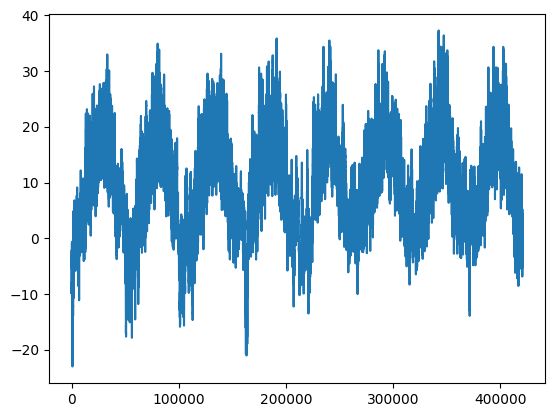

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

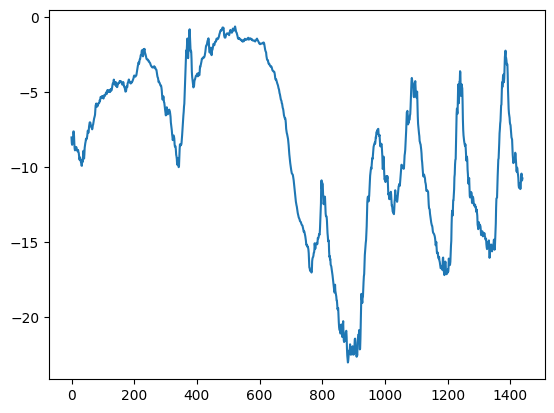

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 52ms/step - loss: 11.7208 - mae: 2.6642 - val_loss: 10.9483 - val_mae: 2.5955
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 8.6725 - mae: 2.3176 - val_loss: 9.7468 - val_mae: 2.4543
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 8.0490 - mae: 2.2289 - val_loss: 11.2533 - val_mae: 2.6530
Epoch 4/10
819/819 [==============================] - 52s 63ms/step - loss: 7.6744 - mae: 2.1751 - val_loss: 10.7280 - val_mae: 2.5806
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 7.4074 - mae: 2.1370 - val_loss: 11.6536 - val_mae: 2.6953
Epoch 6/10
819/819 [==============================] - 50s 60ms/step - loss: 7.1727 - mae: 2.1029 - val_loss: 11.6265 - val_mae: 2.6893
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 7.0138 - mae: 2.0813 - val_loss: 10.7320 - val_mae: 2.5828
Epoch 8/10
819/819 [==============================] - 4

**Plotting results**

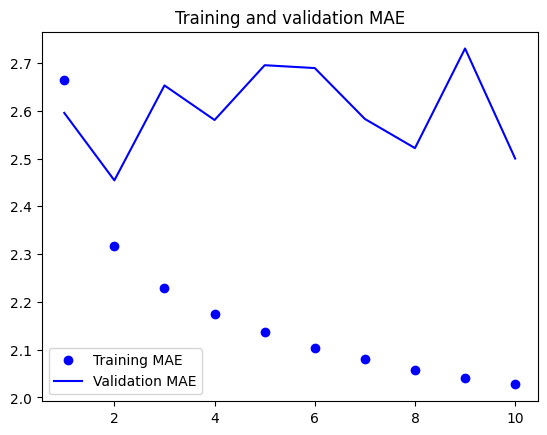

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 53ms/step - loss: 24.3996 - mae: 3.8458 - val_loss: 16.8061 - val_mae: 3.2767
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 16.0034 - mae: 3.1643 - val_loss: 15.5534 - val_mae: 3.1139
Epoch 3/10
819/819 [==============================] - 53s 65ms/step - loss: 14.5355 - mae: 3.0044 - val_loss: 14.8516 - val_mae: 3.0470
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 13.5339 - mae: 2.8977 - val_loss: 15.0849 - val_mae: 3.0658
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 12.7465 - mae: 2.8123 - val_loss: 15.9991 - val_mae: 3.1617
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 12.1209 - mae: 2.7438 - val_loss: 14.6591 - val_mae: 3.0260
Epoch 7/10
819/819 [==============================] - 54s 66ms/step - loss: 11.6199 - mae: 2.6868 - val_loss: 16.5706 - val_mae: 3.2010
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 64s 73ms/step - loss: 46.3600 - mae: 4.9614 - val_loss: 12.9884 - val_mae: 2.7233
Epoch 2/10
819/819 [==============================] - 60s 73ms/step - loss: 11.1926 - mae: 2.5971 - val_loss: 9.5275 - val_mae: 2.4036
Epoch 3/10
819/819 [==============================] - 57s 69ms/step - loss: 9.9426 - mae: 2.4604 - val_loss: 9.5737 - val_mae: 2.4144
Epoch 4/10
819/819 [==============================] - 56s 68ms/step - loss: 9.5896 - mae: 2.4144 - val_loss: 9.7395 - val_mae: 2.4321
Epoch 5/10
819/819 [==============================] - 58s 70ms/step - loss: 9.3304 - mae: 2.3779 - val_loss: 9.9081 - val_mae: 2.4492
Epoch 6/10
819/819 [==============================] - 53s 65ms/step - loss: 9.1420 - mae: 2.3537 - val_loss: 9.9554 - val_mae: 2.4526
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 8.9661 - mae: 2.3293 - val_loss: 9.8842 - val_mae: 2.4405
Epoch 8/10
819/819 [==============================] - 54s 6

## Understanding recurrent neural networks

A major characteristic of all neural networks you’ve seen so far, such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept between inputs. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go. Such networks are called *feedforward networks*.

 In contrast, as you're reading the present sentence, you're processing it word by word—or rather, eye saccade by eye saccade—while keeping memories of what came before; this gives you a fluid representation of the meaning conveyed by this sentence.

A *recurrent neural network* (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a *state* that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal *loop* (see figure below).

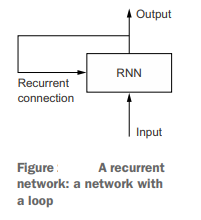

The state of the RNN is reset between processing two different, independent sequences (such as two samples in a batch), so you still consider one sequence to be a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequence elements.

To make these notions of *loop* and *state* clear, let's implement the forward pass of a toy RNN. This RNN takes as input a sequence of vectors, which we'll encode as a rank-2 tensor of size `(timesteps, input_features)`. It loops over timesteps, and at each timestep, it considers its current state at t and the input at `t` (of shape `(input_features,)`, and combines them to obtain the output at `t`. We'll then set the state for the next step
to be this previous output. For the first timestep, the previous output isn't defined; hence, there is no current state. So we'll initialize the state as an all-zero vector called the initial state of the network.

In pseudocode, this is the RNN.

**Pseudocode RNN**

In [ ]:
state_t = 0                            # the state at t
for input_t in input_sequence:         # iterate over sequence elements
 output_t = f(input_t, state_t)
 state_t = output_t                    # The previous output becomes the state for the next iteration

You can even flesh out the function `f`: the transformation of the input and state into an output will be parameterized by two matrices, `W` and `U`, and a bias vector. It's similar to the transformation operated by a densely connected layer in a feedforward network.

**More-detailed pseudocode for the RNN**

In [ ]:
state_t = 0
for input_t in input_sequence:
 output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
 state_t = output_t

To make these notions absolutely unambiguous, let’s write a naive NumPy implementation of the forward pass of the simple RNN.

**NumPy implementation of a simple RNN**

In [16]:
import numpy as np
timesteps = 100                                                                 # Number of timesteps in the input sequence
input_features = 32                                                             # Dimensionality of the input feature space
output_features = 64                                                            # Dimensionality of the ouput feature space
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))                                          # Initial state: an all-zero vector
W = np.random.random((output_features, input_features))                         # Creates random weight matrices
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:                                                          # input_t is a vector of shape (input_features,).
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)             # Combines the input with the current state (the
                                                                                # previous output) to obtain the current output.
                                                                                # We use tanh to addnon-linearity (we could use
                                                                                # any other activation function).
    successive_outputs.append(output_t)                                         # Stores this output in a list
    state_t = output_t                                                          # Updates the state of the network for the next timestep
final_output_sequence = np.stack(successive_outputs, axis=0)                    # The final output is a rank-2 tensor of shape
                                                                                # (timesteps, output_features).

That's easy enough. In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more. Of course, there are many different RNNs fitting this definition that you could build—this example is one of the simplest RNN formulations. RNNs are characterized by their step function, such as the following function in this case (see figure below).

`output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)`

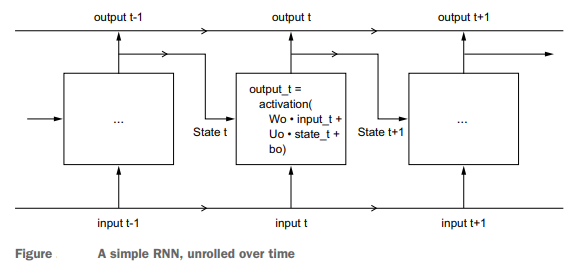

*Remark:* In this example, the final output is a rank-2 tensor of shape `(timesteps, output_features)`, where each timestep is the output of the loop at time `t`. Each timestep `t` in the output tensor contains information about timesteps 0 to t in the input sequence—about the entire past. For this reason, in many cases, you don't need this full sequence of outputs; you just need the last output (`output_t` at the end of the loop), because it already contains information about the entire sequence.

### A recurrent layer in Keras

The process we just naively implemented in NumPy corresponds to an actual Keras layer—the `SimpleRNN` layer.

There is one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the NumPy example. This means it takes inputs of shape `(batch_size, timesteps,input_features)`, rather than `(timesteps,input_features)`. When specifying the shape argument of the initial `Input()`, note that you can set the `timesteps` entry to `None`, which enables your network to process
sequences of arbitrary length.

**An RNN layer that can process sequences of any length**

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

This is especially useful if your model is meant to process sequences of variable length. However, if all of your sequences have the same length, I recommend specifying a complete input shape, since it enables `model.summary()` to display output length information, which is always nice, and it can unlock some performance optimizations.

All recurrent layers in Keras (`SimpleRNN`, `LSTM`, and `GRU`) can be run in two different modes: they can return either full sequences of successive outputs for each timestep (a rank-3 tensor of shape `(batch_size, timesteps, output_features)`) or return only the last output for each input sequence (a rank-2 tensor of shape `(batch_size, output_features)`). These two modes are controlled by the return_sequences constructor argument. Let's look at an example that uses SimpleRNN and returns only the output at the last timestep.

**An RNN layer that returns only its last output step**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)                  # Note that return_sequences=False is the default.
print(outputs.shape)

(None, 16)


The following example returns the full state sequence.

**An RNN layer that returns its full output sequence**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


It's sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.

**Stacking RNN layers**

In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In practice, you'll rarely work with the `SimpleRNN` layer. It's generally too simplistic to be of real use. In particular, `SimpleRNN` has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, such
long-term dependencies prove impossible to learn in practice. This is due to the *vanishing gradient problem*, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. The theoretical reasons for this effect were studied by Hochreiter, Schmidhuber, and Bengio in the early 1990s.

Thankfully, SimpleRNN isn't the only recurrent layer available in Keras. There are two others, *LSTM* and *GRU*, which were designed to address these issues.

Let's consider the *LSTM* layer. The underlying Long Short-Term Memory (LSTM)algorithm was developed by Hochreiter and Schmidhuber in 1997;
it was the culmination of their research on the vanishing gradient problem.

This layer is a variant of the `SimpleRNN` layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you're processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing. This should remind you of *residual connections*, which you learned about in chapter 9: it's pretty much the same idea.

To understand this process in detail, let's start from the `SimpleRNN` cell (see figure below). Because you'll have a lot of weight matrices, index the `W` and `U` matrices in the cell, with the letter `o` (`Wo` and `Uo`) for output.

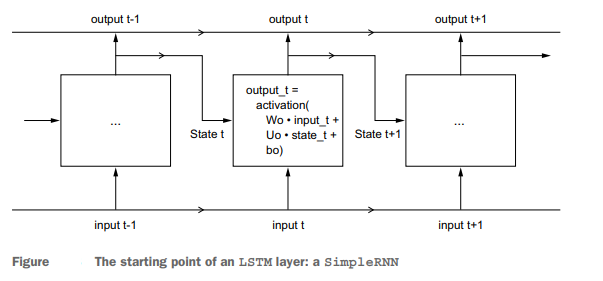

Let's add to this picture an additional data flow that carries information across timesteps. Call its values at different timesteps `c_t`, where C stands for *carry*. This information will have the following impact on the cell: it will be combined with the input connection and the recurrent connection (via a dense transformation: a dot product with a weight matrix followed by a bias add and the application of an activation function), and it will affect the state being sent to the next timestep (via an activation function and a multiplication operation). Conceptually, the carry dataflow is a way to modulate the next output and the next state (see figure below).

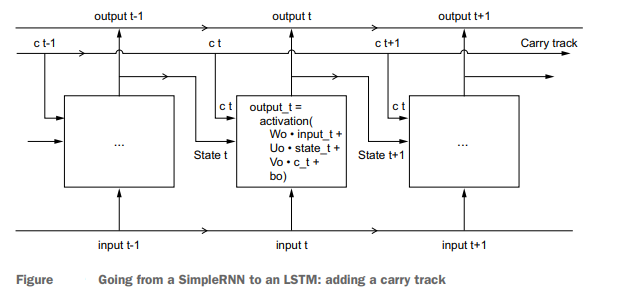

Now the subtlety—the way the next value of the carry dataflow is computed. It involves three distinct transformations. All three have the form of a `SimpleRNN` cell:

`y = activation(dot(state_t, U) + dot(input_t, W) + b)`

But all three transformations have their own weight matrices, which we’ll index with the letters `i`, `f`, and `k`. Here's what we have so far (it may seem a bit arbitrary, but bear with me).

**Pseudocode details of the LSTM architecture (1/2)**

In [ ]:
output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

**Pseudocode details of the LSTM architecture (2/2)**

In [ ]:
c_t+1 = i_t * k_t + c_t * f_t

Add this as shown in figure 10.10, and that's it. Not so complicated—merely a tad complex.

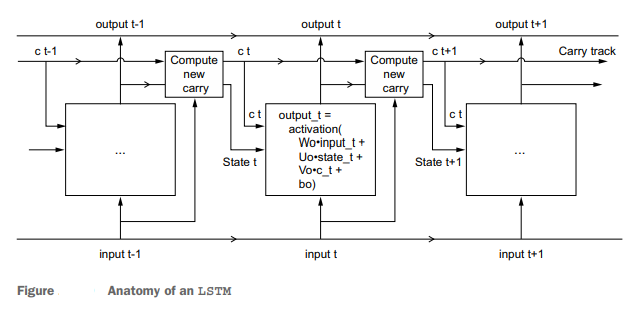

If you want to get philosophical, you can interpret what each of these operations is meant to do. For instance, you can say that multiplying `c_t` and `f_t` is a way to deliberately forget irrelevant information in the carry dataflow. Meanwhile, `i_t` and `k_t` provide information about the present, updating the carry track with new information.

But at the end of the day, these interpretations don't mean much, because what these operations *actually* do is determined by the contents of the weights parameterizing them; and the weights are learned in an end-to-end fashion, starting over with each training round, making it impossible to credit this or that operation with a specific purpose. The specification of an RNN cell (as just described) determines your hypothesis space—the space in which you'll search for a good model configuration during training—but it doesn't determine what the cell does; that is up to the cell weights. The same cell with different weights can be doing very different things. So the combination of operations making up an RNN cell is better interpreted as a set of *constraints* on your search, not as a *design* in an engineering sense.

Arguably, the choice of such constraints—the question of how to implement RNN cells—is better left to optimization algorithms (like genetic algorithms or reinforcement learning processes) than to human engineers. In the future, that's how we'll build our models. In summary: you don't need to understand anything about the specific architecture of an LSTM cell; as a human, it shouldn't be your job to understand it. Just keep in mind what the LSTM cell is meant to do: allow past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

## Advanced use of recurrent neural networks

We'll now cover the following:
- *Recurrent dropout*—This is a variant of dropout, used to fight overfitting in recurrent layers.
- *Stacking recurrent layers*—This increases the representational power of the model
(at the cost of higher computational loads).
- *Bidirectional recurrent layers*—These present the same information to a recurrent
network in different ways, increasing accuracy and mitigating forgetting issues.

We'll use these techniques to refine our temperature-forecasting RNN.

### Using recurrent dropout to fight overfitting

Let's go back to the LSTM-based model we used in section 10.2.5—our first model able to beat the common-sense baseline. If you look at the training and validation curves (figure 10.5), it's evident that the model is quickly overfitting, despite only having very few units: the training and validation losses start to diverge considerably after a few epochs. You're already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn't a trivial question.


It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2016, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. What's more, in order to regularize the representations formed by the recurrent gates of layers such as `GRU` and `LSTM`, a temporally
constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let's add recurrent dropout to the LSTM layer of our first `LSTM` example and see how doing so impacts overfitting.

Thanks to dropout, we won't need to rely as much on network size for regularization, so we'll use an LSTM layer with twice as many units, which should, hopefully, be more expressive (without dropout, this network would have started overfitting right away—try it). Because networks being regularized with dropout always take much longer to fully converge, we'll train the model for five times as many epochs.

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)                                                      # To regularize the Dense layer, we also add a Dropout layer
                                                                                # after the LSTM.
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 444s 537ms/step - loss: 28.5535 - mae: 3.9433 - val_loss: 10.1467 - val_mae: 2.4776
Epoch 2/50
819/819 [==============================] - 443s 541ms/step - loss: 14.9003 - mae: 2.9989 - val_loss: 9.8578 - val_mae: 2.4538
Epoch 3/50
819/819 [==============================] - 456s 556ms/step - loss: 14.2577 - mae: 2.9286 - val_loss: 9.2836 - val_mae: 2.3800
Epoch 4/50
439/819 [===============>..............] - ETA: 3:23 - loss: 13.9273 - mae: 2.8901

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

The figure above shows the results. Success! We're no longer overfitting during the first 20 epochs. We achieve a validation MAE as low as 2.27 degrees (7% improvement over the no-learning baseline) and a test MAE of 2.45 degrees (6.5% improvement over the baseline). Not too bad.

**RNN Runtime Performance:** Recurrent models with very few parameters, like the ones in this chapter, tend to be significantly faster on a multicore CPU than on GPU, because they only involve small matrix multiplications, and the chain of multiplications is not well parallelizable due to the presence of a *for* loop. But larger RNNs can greatly benefit from a GPU runtime.

When using a Keras `LSTM` or `GRU` layer on GPU with default keyword arguments, your layer will be leveraging a cuDNN kernel, a highly optimized, low-level, NVIDIA-provided implementation of the underlying algorithm (I mentioned these in the previous chapter). As usual, cuDNN kernels are a mixed blessing: they're fast, but inflexible—if you
try to do anything not supported by the default kernel, you will suffer a dramatic slowdown, which more or less forces you to stick to what NVIDIA happens to provide. For instance, recurrent dropout isn't supported by the LSTM and GRU cuDNN kernels, so adding it to your layers forces the runtime to fall back to the regular TensorFlow implementation, which is generally two to five times slower on GPU (even though its computational cost is the same).

As a way to speed up your RNN layer when you can't use cuDNN, you can try *unrolling* it. Unrolling a `for` loop consists of removing the loop and simply inlining its content `N` times. In the case of the `for` loop of an RNN, unrolling can help TensorFlow optimize the underlying computation graph. However, it will also considerably increase the memory consumption of your RNN—as such, it's only viable for relatively small sequences (around 100 steps or fewer). Also, note that you can only do this if the
number of timesteps in the data is known in advance by the model (that is to say, if you pass a shape without any None entries to your initial `Input()`). It works like this:


**RNN Runtime**

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))                     # sequence_length cannot be None
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)                 # Pass unroll=True to enable unrolling.

Because you're no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it's generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle
(assuming you're already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren't overfitting too badly, you're likely under capacity.

TODO: FIX FROM HERE!

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### Going even further

## Summary